# Homework 6

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O housing.csv

--2022-10-14 08:12:39--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  6.03MB/s    in 0.2s    

2022-10-14 08:12:40 (6.03 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

## Loading the data

In [3]:
# Dataset loading
df = pd.read_csv('housing.csv')

# Selected columns filtering
selected_columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'
]
df = df[selected_columns]

# NA filling
df = df.fillna(0)

# Log transform
df['median_house_value'] = np.log1p(df['median_house_value'])

# Dataset splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Dictionary vectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

- Train a model with `max_depth=1`.

Which feature is used for splitting the data?

- `ocean_proximity=INLAND`
- `total_rooms`
- `latitude`
- `population`

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/user/.virtualenvs/06-trees-JKd2VfRg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?

- 0.05
- 0.25
- 0.55
- 0.85

In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rmse = mean_squared_error(y_pred, y_val, squared=False)

print("%.2f" % rmse)

0.25


## Question 3

Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 50
- 70
- 150

In [37]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    rmse = mean_squared_error(y_pred, y_val, squared=False)

    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [38]:
df_scores

,n_estimators,rmse
0,10,0.245660
1,20,0.238831
2,30,0.235335
3,40,0.234257
4,50,0.232991
5,60,0.232767
6,70,0.232337
7,80,0.232403
8,90,0.232107
9,100,0.231928


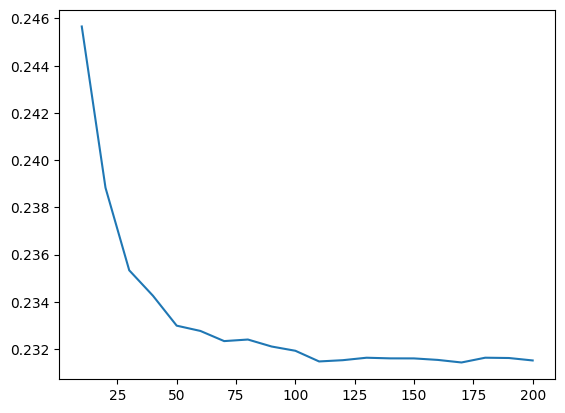

In [39]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
- Fix the random seed: `random_state=1`

What's the best `max_depth`:

- 10
- 15
- 20
- 25

In [11]:
scores = []

for depth in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=depth, n_estimators=n, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        
        rmse = mean_squared_error(y_pred, y_val, squared=False)
        
        scores.append((depth, n, rmse))

In [12]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                     
max_depth        10     15     20     25
n_estimators                            
10            0.255  0.245  0.246  0.246
20            0.253  0.239  0.238  0.239
30            0.251  0.237  0.236  0.236
40            0.251  0.236  0.235  0.235
50            0.250  0.235  0.233  0.233
60            0.250  0.235  0.233  0.233
70            0.250  0.234  0.233  0.232
80            0.250  0.234  0.233  0.232
90            0.249  0.234  0.232  0.232
100           0.249  0.234  0.232  0.232
110           0.249  0.233  0.232  0.231
120           0.249  0.233  0.232  0.231
130           0.249  0.233  0.232  0.232
140           0.249  0.233  0.232  0.231
150           0.249  0.233  0.232  0.232
160           0.249  0.233  0.232  0.231
170           0.249  0.233  0.232  0.231
180           0.249  0.233  0.232  0.232
190           0.249  0.233  0.232  0.232
200           0.249  0.233  0.232  0.231

<AxesSubplot: xlabel='None-max_depth', ylabel='n_estimators'>

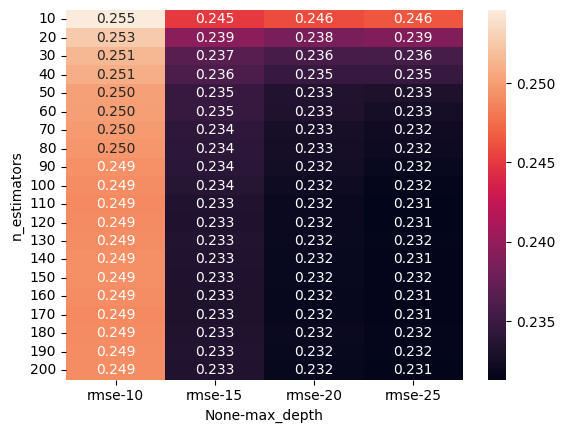

In [13]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

## Question 5

- Train the model with these parametes:
    - `n_estimators=10`,
    - `max_depth=20`,
    - `random_state=1`,
    - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature?

- `total_rooms`
- `median_income`
- `total_bedrooms`
- `longitude`

In [17]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
sorted(list(zip(dv.get_feature_names(), rf.feature_importances_)), key=lambda k: k[1], reverse=True)

/home/user/.virtualenvs/06-trees-JKd2VfRg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('median_income', 0.3633258427603735),
 ('ocean_proximity=INLAND', 0.3109008417080609),
 ('latitude', 0.10125584919636603),
 ('longitude', 0.09647021370105628),
 ('housing_median_age', 0.03314545802888494),
 ('population', 0.030776921187228586),
 ('total_rooms', 0.020541113124599636),
 ('total_bedrooms', 0.01917163182045455),
 ('households', 0.016387382721975895),
 ('ocean_proximity=NEAR OCEAN', 0.004698766933197919),
 ('ocean_proximity=<1H OCEAN', 0.0024888027585429112),
 ('ocean_proximity=NEAR BAY', 0.00048036979631206085),
 ('ocean_proximity=ISLAND', 0.0003568062629467623)]

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both gives same

In [18]:
import re

features = dv.get_feature_names()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
features = [regex.sub("_", f) if any(x in str(f) for x in set(('[', ']', '<'))) else f for f in features]

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [27]:
scores = {}

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [28]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [29]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [30]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [31]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

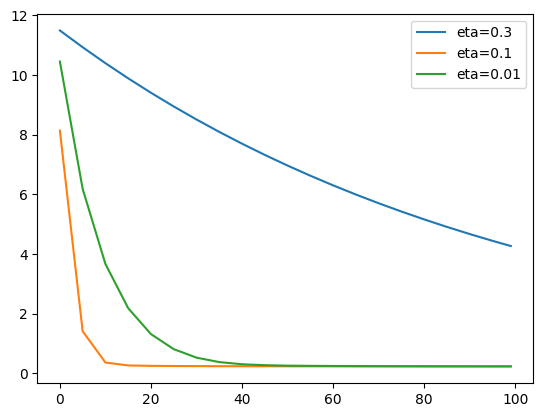

In [32]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()

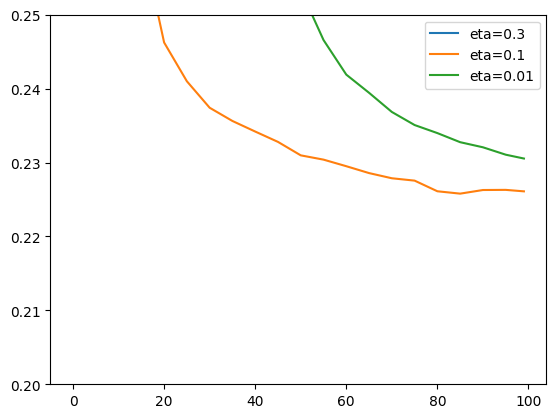

In [34]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.ylim(0.2, 0.25)
plt.legend()